In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")  # Use first RTX 3090
print(f"\nUsing device: {device}")


Using device: cuda:0


In [3]:
data = np.loadtxt("averages_output.dat")
torch_tensor = torch.from_numpy(data)

X_data = torch_tensor[:, 1:6]
y_data = torch_tensor[:, 6:]

X_combined = X_data.reshape(-1, 5)
y_combined = y_data.reshape(-1, 4)

In [4]:
train_split = int(0.8 * len(X_combined))

X_train, X_test = X_combined[:train_split], X_combined[train_split:]
y_train, y_test = y_combined[:train_split], y_combined[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(800000, 200000, 800000, 200000)

In [5]:
X_train = X_train.to(device)
X_test = X_test.to(device)  
y_train = y_train.to(device)
y_test = y_test.to(device)

,T,TV,TS,LV,LS,CE,MV,STDV,MS,STDS
count,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,10.0,87.449168,45.660113,10.000029,7.497525,7.504350,86.275413,0.726561,48.516134,0.750546
std,0.0,36.081976,19.135010,2.885135,4.329405,4.329673,36.405156,0.124169,15.774448,0.556963
min,10.0,25.000000,10.000000,5.000000,0.000015,0.000001,12.583339,0.000000,14.344205,0.000000
25%,10.0,56.000000,30.140000,7.498000,3.755000,3.758000,54.832009,0.627110,37.103515,0.369156
50%,10.0,87.000000,43.200000,10.000000,7.491000,7.504000,86.396589,0.701134,46.351828,0.723496
75%,10.0,119.000000,59.310000,12.500000,11.250000,11.260000,117.751248,0.810920,57.943594,0.993352
max,10.0,150.000000,97.950000,15.000000,15.000000,15.000000,149.972455,1.853903,164.946646,28.567272


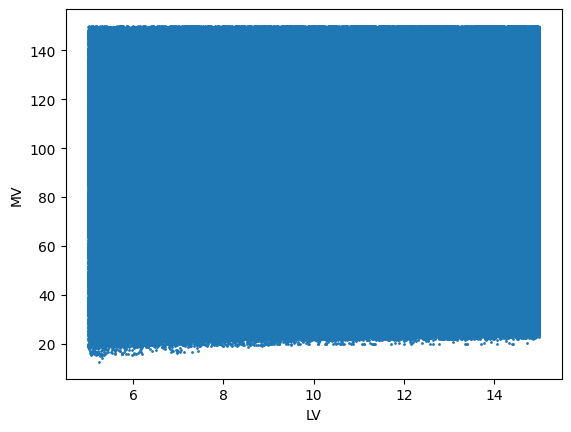

In [6]:
headers = ["T", "TV", "TS", "LV", "LS", "CE", "MV", "STDV", "MS", "STDS"]

df = pd.read_csv('averages_output.dat', delimiter='\t', header=None, names=headers)

def plot(dataset, x='', y=''):
    dataset.plot(x=x, y=y, kind='scatter', s=1)
    return()
plot(df, x='LV', y='MV')

df.describe()

In [7]:
from torch import nn
class NonLinearModule(nn.Module): # explain
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(5, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 4)
        
        # use exact same structure as previous; dont add features + layers
        # if not enough, add a layer with 256 features

        # save model, then start over from previously trained model

        # next steps
            # get loss low
            # publish on website
            # documentation -> claude

        self.relu = nn.ReLU()

    def forward(self, x):
        return (self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))))

In [8]:
torch.manual_seed(42)

model_3 = NonLinearModule().to(device)

In [9]:
with torch.inference_mode():
    untrained_preds = model_3(X_test.float())

untrained_preds

tensor([[ 0.9103,  0.0242, -1.8993,  2.0304],
        [ 0.9592, -0.1397, -4.2614,  4.2953],
        [ 1.3679, -0.7030, -4.8536,  4.7644],
        ...,
        [ 0.0857,  0.1251, -2.9581,  3.0959],
        [ 0.2481, -0.2300, -4.1387,  4.1909],
        [ 0.7962, -0.4421, -4.7189,  4.6223]], device='cuda:0')

In [51]:
loss = nn.L1Loss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.1)

In [22]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8192

train_dataloader = DataLoader(dataset=TensorDataset(X_train, y_train), 
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=TensorDataset(X_test, y_test), 
                              batch_size=batch_size,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1427ac4c550>,
 <torch.utils.data.dataloader.DataLoader at 0x1427ac4fcd0>)

In [23]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {batch_size}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {batch_size}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001427AC4C550>, <torch.utils.data.dataloader.DataLoader object at 0x000001427AC4FCD0>)
Length of train_dataloader: 98 batches of 8192...
Length of test_dataloader: 25 batches of 8192...


In [54]:
epochs = 5

# track different values
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_3.train()
    
    train_loss = 0
    train_batches = 0
    
    for batch_X, batch_y in train_dataloader:
        # 1 - forward pass
        y_pred = model_3(batch_X.float())
        
        # 2 - loss calculation
        loss_val = loss(y_pred, batch_y)
        
        # 3 - optimizer zero grad
        optimizer.zero_grad()
        
        # 4 - loss backpropagation
        loss_val.backward()
        
        # 5 - optimizer step
        optimizer.step()
        
        train_loss += loss_val.item()
        train_batches += 1
    
    # Calculate average training loss
    avg_train_loss = train_loss / train_batches
    
    model_3.eval()
    
    test_loss = 0
    test_batches = 0
    
    with torch.inference_mode():
        for batch_X_test, batch_y_test in test_dataloader:
            # Forward pass on test batch
            test_pred = model_3(batch_X_test.float())
            batch_test_loss = loss(test_pred, batch_y_test)
            
            test_loss += batch_test_loss.item()
            test_batches += 1
    
    # Calculate average test loss
    avg_test_loss = test_loss / test_batches
    
    if epoch % 1 == 0:
        epoch_count.append(epoch)
        loss_values.append(avg_train_loss)
        test_loss_values.append(avg_test_loss)
        print(f"Epoch: {epoch} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch: 0 | Train Loss: 0.132420 | Test Loss: 0.132326
Epoch: 1 | Train Loss: 0.132418 | Test Loss: 0.132326
Epoch: 2 | Train Loss: 0.132420 | Test Loss: 0.132326
Epoch: 3 | Train Loss: 0.132428 | Test Loss: 0.132326
Epoch: 4 | Train Loss: 0.132426 | Test Loss: 0.132326


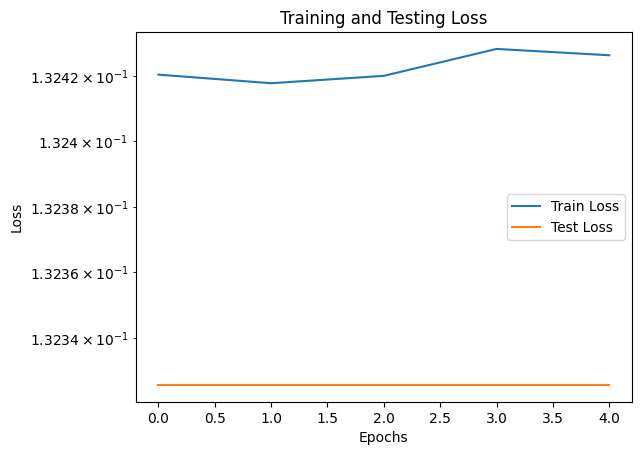

In [55]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Training and Testing Loss")
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [73]:
headers = ["T", "TV", "TS", "LV", "LS", "CE", "MV", "STDV", "MS", "STDS"]
df = pd.read_csv('averages_output.dat', delimiter='\t', header=None, names=headers)

df.head()

,T,TV,TS,LV,LS,CE,MV,STDV,MS,STDS
0,10.0,77.0,65.76,12.200,12.480,3.303,76.738254,0.639004,65.871955,0.493426
1,10.0,67.0,19.58,7.440,13.980,2.322,63.976220,0.566984,32.104376,0.408397
2,10.0,137.0,84.77,9.701,11.360,10.740,136.263318,0.710100,83.980018,0.290642
3,10.0,78.0,40.18,11.860,13.040,8.696,77.119078,0.645937,40.013839,0.167992
4,10.0,97.0,44.97,6.869,9.583,11.250,95.289424,0.858749,44.426733,0.819800


In [61]:
TV_threshold = df['TV'].quantile(0.8)
TS_threshold = df['TS'].quantile(0.2)

LV_threshold = df['LV'].quantile(0.5)
LS_threshold = df['LS'].quantile(0.5)

filtered = df[(df['TS'] <= TS_threshold) & (df['TV'] >= TV_threshold) & (df['LV'] >= LV_threshold) & (df['LS'] >= LS_threshold)]
filtered.head()

,T,TV,TS,LV,LS,CE,MV,STDV,MS,STDS
184,10.0,137.0,23.89,12.01,7.765,7.601,136.130668,0.636719,49.834597,0.303244
939,10.0,138.0,26.12,12.43,11.760,4.377,137.185930,0.624997,48.182364,0.523559
1295,10.0,134.0,25.67,13.87,14.880,0.115,133.710901,0.589008,48.015832,0.164199
1334,10.0,129.0,25.41,14.87,14.470,2.690,128.513566,0.586792,47.276025,0.665133
1394,10.0,142.0,24.54,13.35,8.023,5.666,141.164940,0.603251,50.000000,0.000000


In [ ]:
output = []
'''
TV = 77
TS = 65.76
LV = 12.2
LS = 12.48
CE = 3.303
'''

TV = 134
TS = 25.67
LV = 13.87
LS = 14.88
CE = 0.115

input_data = torch.tensor([TV, TS, LV, LS, CE], dtype=torch.float32).to(device)
model = model_3
with torch.no_grad():
    outputm = model(input_data)
print(outputm)

tensor([133.6739,   0.5857,  47.5508,   0.6042], device='cuda:0')


In [34]:
print("Output ranges:")
for i, name in enumerate(['MV', 'STDV', 'MS', 'STDS']):
    output_range = y_train[:, i].max() - y_train[:, i].min()
    print(f"{name}: {y_train[:, i].min():.3f} to {y_train[:, i].max():.3f} (range: {output_range:.3f})")

loss_percentage = loss_val / output_range * 100
print(f"Loss is {loss_percentage:.1f}% of output range")

Output ranges:
MV: 12.583 to 149.972 (range: 137.389)
STDV: 0.000 to 1.854 (range: 1.854)
MS: 14.344 to 135.260 (range: 120.916)
STDS: 0.000 to 19.633 (range: 19.633)
Loss is 0.7% of output range


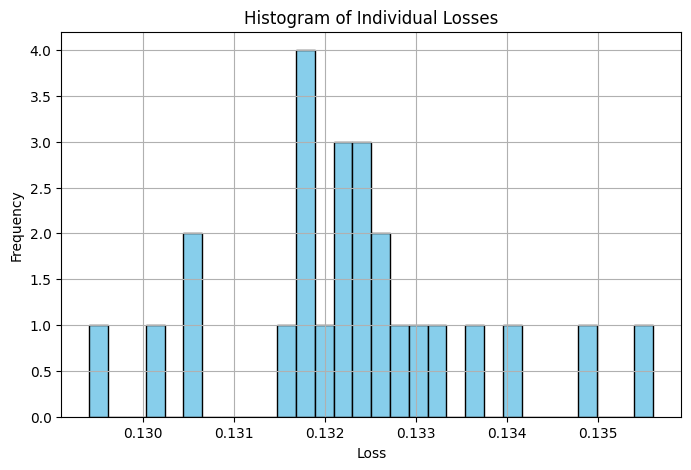

In [69]:
model_3.eval()

# Store individual losses

individual_losses = []

# Disable gradient computation for evaluation

with torch.no_grad():

    for batch_X_test, batch_y_test in test_dataloader:
        # Forward pass on test batch
        test_pred = model_3(batch_X_test.float())
        batch_test_loss = loss(test_pred, batch_y_test)
            
        test_loss = batch_test_loss.item()

        individual_losses.append(test_loss)

plt.figure(figsize=(8, 5))

plt.hist(individual_losses, bins=30, color='skyblue', edgecolor='black')

plt.title('Histogram of Individual Losses')

plt.xlabel('Loss')

plt.ylabel('Frequency')

plt.grid(True)

plt.show()

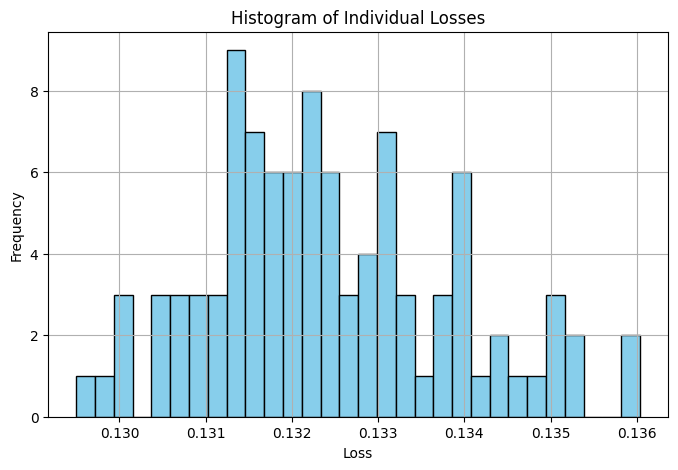

In [70]:
model_3.eval()

# Store individual losses

individual_losses = []

# Disable gradient computation for evaluation

with torch.no_grad():

    for batch_X_test, batch_y_test in train_dataloader:
        # Forward pass on test batch
        test_pred = model_3(batch_X_test.float())
        batch_test_loss = loss(test_pred, batch_y_test)
            
        test_loss = batch_test_loss.item()

        individual_losses.append(test_loss)

plt.figure(figsize=(8, 5))

plt.hist(individual_losses, bins=30, color='skyblue', edgecolor='black')

plt.title('Histogram of Individual Losses')

plt.xlabel('Loss')

plt.ylabel('Frequency')

plt.grid(True)

plt.show()

In [71]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "CC3D_final.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_3.state_dict(), f=MODEL_SAVE_PATH)

# torch.save(obj=model_3.state_dict(), f=MODEL_SAVE_PATH)

In [72]:
#model.load_state_dict(torch.load("models/CC3D.pth", weights_only=False))
model_3 = NonLinearModule()
model_3.load_state_dict(torch.load('models/CC3D_final.pth'))
model_3.eval()
model_3.to(device)

NonLinearModule(
  (layer_1): Linear(in_features=5, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
)